In [10]:
import numpy as np
import tensorflow as tf
import pathlib
from sklearn.decomposition import PCA

# Define dataset path
dataset_path = "datasets/train"  # Change to your actual dataset path
dataset_path = pathlib.Path(dataset_path)  # Convert to pathlib object

# Load dataset
batch_size = 32
img_height = 500
img_width = 500

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Check class names
class_names = train_ds.class_names
print("Class Names:", class_names)

# Normalize the dataset (RGB values from 0-255 to 0-1)
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Convert dataset to numpy arrays
def dataset_to_numpy(dataset):
    image_data = []
    labels = []
    for images, lbls in dataset:
        for img, lbl in zip(images, lbls):
            image_data.append(img.numpy().flatten())  # Flatten to 1D vector
            labels.append(lbl.numpy())
    return np.array(image_data), np.array(labels)

X_train, y_train = dataset_to_numpy(train_ds)
X_val, y_val = dataset_to_numpy(val_ds)

print("Original shape:", X_train.shape)  # (num_samples, img_height*img_width*channels)


Found 778 files belonging to 2 classes.
Using 623 files for training.
Found 778 files belonging to 2 classes.
Using 155 files for validation.
Class Names: ['Ai', 'Real']


2025-03-17 09:46:48.664640: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'CMYK': invalid ICC profile color space


Original shape: (623, 750000)


2025-03-17 09:46:49.156188: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


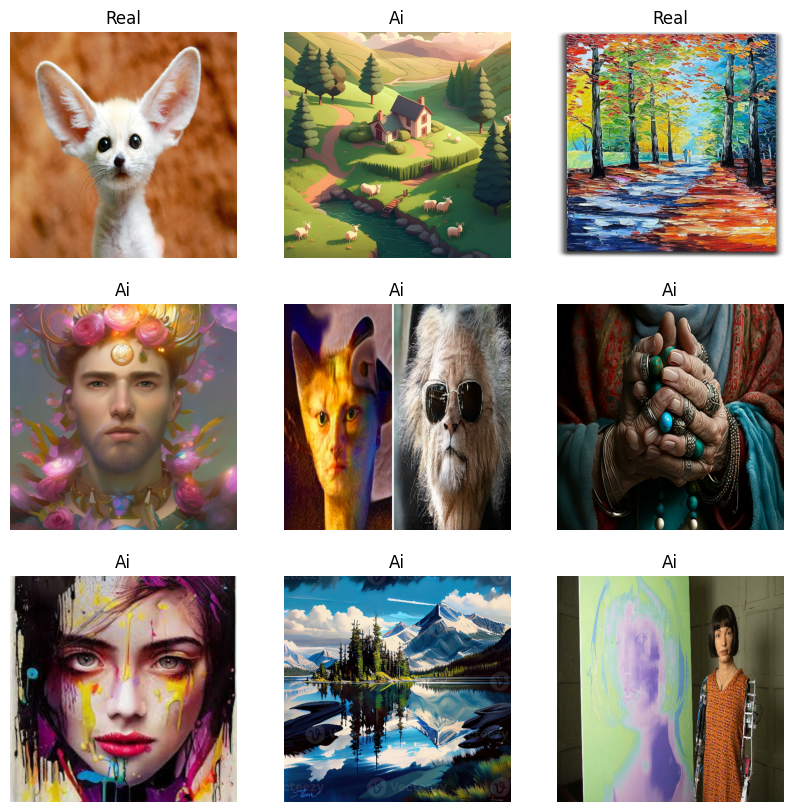

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")
plt.show()


In [12]:
# Reduce dimensions to 100 principal components
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

print("Reduced shape (Train):", X_train_pca.shape)  # (num_samples, 100)
print("Reduced shape (Validation):", X_val_pca.shape)  # (num_samples, 100)

Reduced shape (Train): (623, 100)
Reduced shape (Validation): (155, 100)


In [13]:
# Train KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=21)  # Choose k (number of neighbors)
knn.fit(X_train_pca, y_train)

# Predict and evaluate
y_pred = knn.predict(X_val_pca)
accuracy = accuracy_score(y_val, y_pred)

print("KNN Model Accuracy:", accuracy)


KNN Model Accuracy: 0.6064516129032258


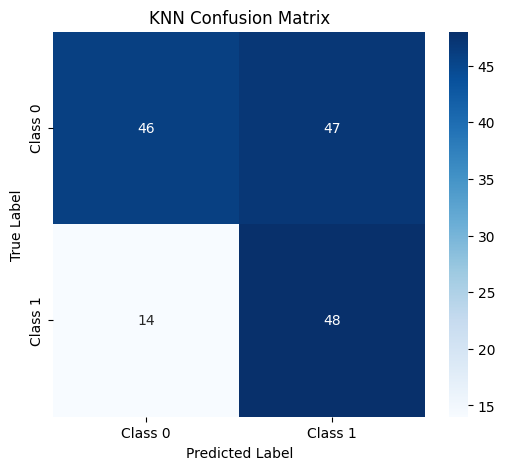

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("KNN Confusion Matrix")
plt.show()


In [15]:
# Optimize for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Define CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D(2),

    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2),

    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')  # Output layer for classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10  # You can change the number of epochs based on your needs
)

# Evaluate the model
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

Epoch 1/10


/Users/hjalle/Desktop/Skola/Maskininlarning/projekt/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5481 - loss: 3.5813

2025-03-17 09:47:54.247066: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'CMYK': invalid ICC profile color space


20/20 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.5479 - loss: 3.5115 - val_accuracy: 0.6000 - val_loss: 0.6768
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.5593 - loss: 0.6714 - val_accuracy: 0.6000 - val_loss: 0.6335
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.5898 - loss: 0.6397 - val_accuracy: 0.6258 - val_loss: 0.6237
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.7279 - loss: 0.5560 - val_accuracy: 0.6645 - val_loss: 0.7491
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.8392 - loss: 0.3505 - val_accuracy: 0.6516 - val_loss: 0.7513
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.9236 - loss: 0.2249 - val_accuracy: 0.5355 - val_loss: 1.6028
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.9432 - loss: 0.1554 - val_accuracy: 0.6452 - val_loss: 1.1528
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.9790 - loss: 0.0682 - val_accuracy: 0.6452 - val_loss: 1.9187
Epo